In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio.v2 as imageio
from tensorflow.keras import layers
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import random

Lets first take a look at the images. Because the images are all separated into separate folders, we can use glob to get all the images.

In [4]:
#Desktop
#images = glob.glob('../data/data*/data*/CameraRGB/*.png')
#masks = glob.glob('../data/data*/data*/CameraSeg/*.png')
#Laptop
images = glob.glob('../data/data*/CameraRGB/*.png')
masks = glob.glob('../data/data*/CameraSeg/*.png')

Here we can see the side by side of the images and masks supplied by the dataset. 

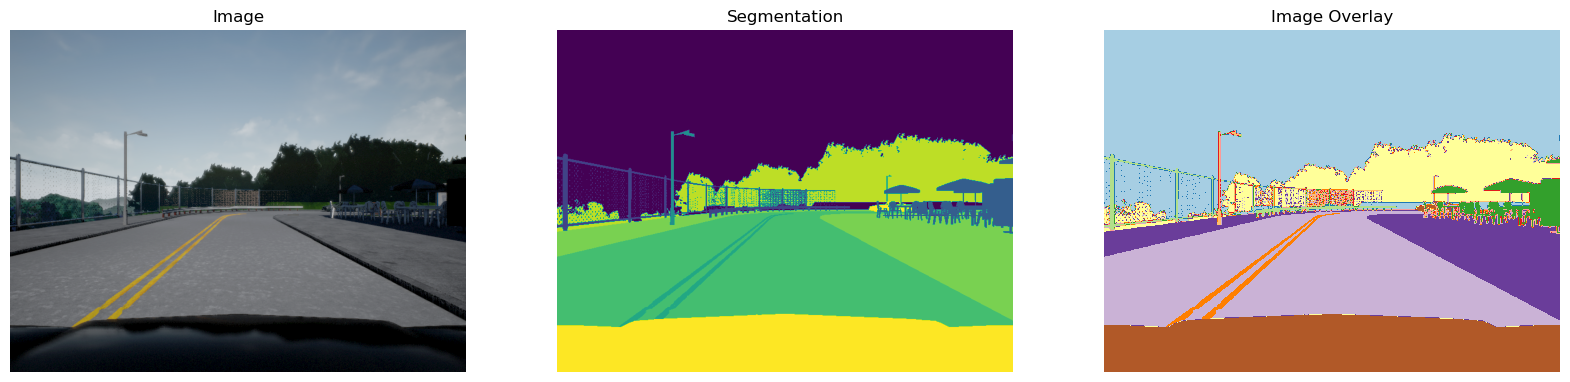

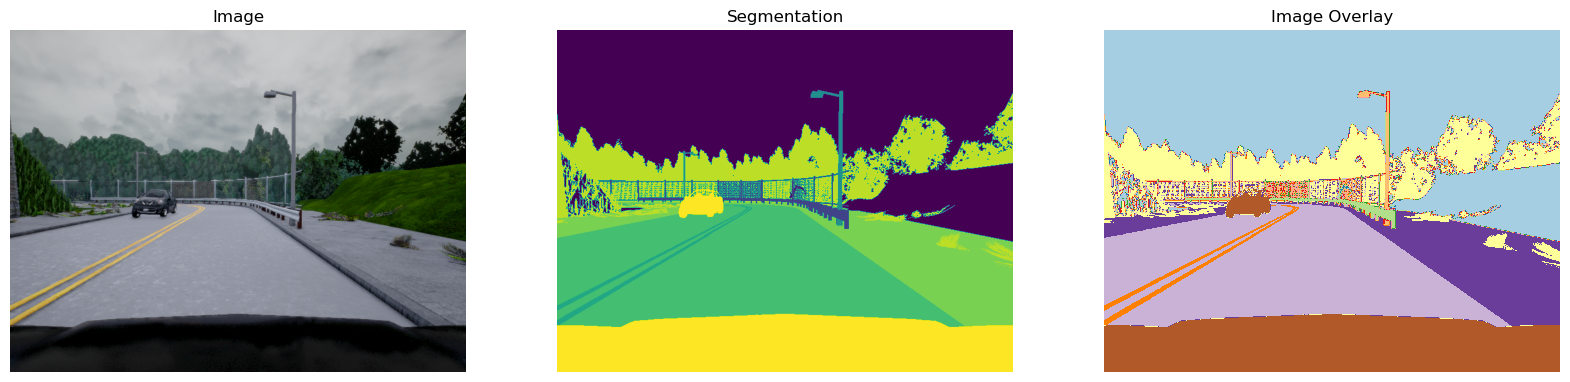

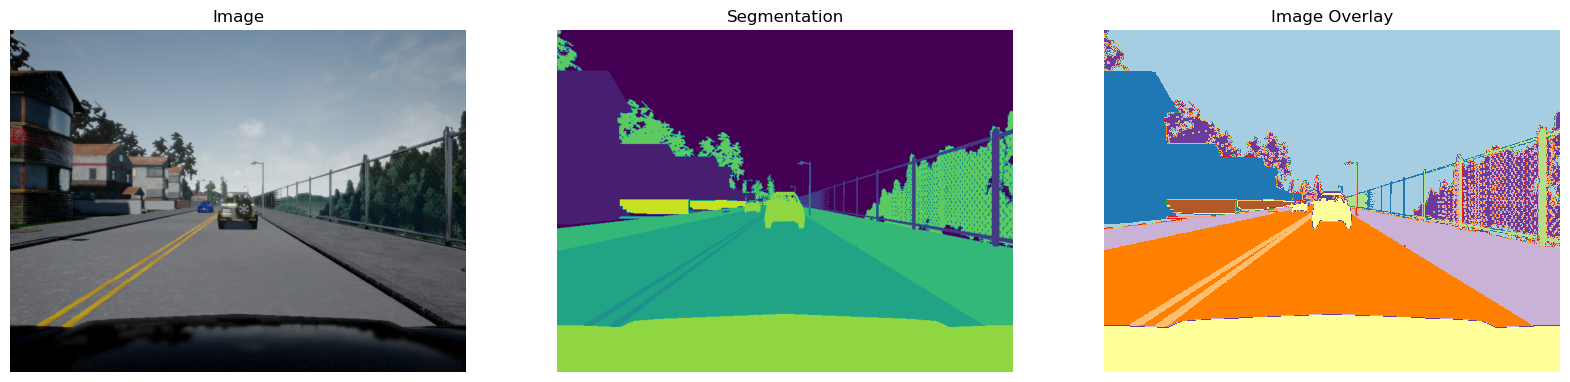

In [5]:
for i in range(3):
    N = random.randint(0, len(images) - 1)

    img = imageio.imread(images[N])
    mask = imageio.imread(masks[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

Now we will load in all the images with tensorflow and store it in a tensorflow dataset. We will create some helper functions so that they can be mapped to a tensorflow dataset

def get_dataset(batch_size, img_paths, mask_paths):
    def load_imgs(img_path, mask_path):
        input_img = tf_io.read_file(img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, (256,256), method='nearest')
        input_img = tf.cast(input_img, tf.float32) / 255.0

        input_mask = tf_io.read_file(mask_path)
        input_mask = tf_io.decode_png(input_mask, channels=1)
        input_mask = tf_image.resize(input_mask, (256,256), method='nearest')
        input_mask = tf_image.convert_image_dtype(input_mask, 'uint8')
        #input_mask -= 1 #Seems data already starts at 0

        return input_img, input_mask
    dataset = tf_data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(load_imgs, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [5]:
def get_dataset(batch_size, img_paths, mask_paths):
    def load_imgs(img_path, mask_path):
        input_img = tf_io.read_file(img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf.image.convert_image_dtype(input_img, tf.float32)
        input_img = tf.image.resize(input_img, (192, 256), method='nearest')

        input_mask = tf_io.read_file(mask_path)
        input_mask = tf_io.decode_png(input_mask, channels=1)
        input_mask = tf.math.reduce_max(input_mask, axis=-1, keepdims=True)
        input_mask = tf.image.resize(input_mask, (192, 256), method='nearest')

        return input_img, input_mask
    image_list = tf.constant(img_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_imgs, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

Before we run the model, we will set aside a validation split

In [6]:
#For now, small sample of data
val_samples = 1000
random.Random(42).shuffle(images)
random.Random(42).shuffle(masks)
#train_img_paths = images[:-val_samples]
#train_mask_paths = masks[:-val_samples]
train_img_paths = images[:2000]
train_mask_paths = masks[:2000]
#val_img_paths = images[-val_samples:]
#val_mask_paths = masks[-val_samples:]
val_img_paths = images[-800:]
val_mask_paths = masks[-800:]

train_data = get_dataset(32, train_img_paths, train_mask_paths)
val_data = get_dataset(32, val_img_paths, val_mask_paths)

We need to figure out how many classes there are. This function should help us 

# First model
Next we'll create a U-Net model where the model first downsamples the inputs before upsampling them back for predictions. We will start off with a model that is not too complex. First we'll define some functions that will help with model creation

In [125]:
def conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.2)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    #Ensures dimension match before concatenation
    target_shape = tf.shape(x)[1:3]
    conv_features = tf.image.resize(conv_features, target_shape)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_filters)
    return x

Now we will create the model

In [ ]:
inputs = layers.Input(shape=(256,256,3))

f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)

bottleneck = conv_block(p4, 1024)

u6 = upsample_block(bottleneck, f4, 512)
u7 = upsample_block(u6, f3, 256)
u8 = upsample_block(u7, f2, 128)
u9 = upsample_block(u8, f1, 64)

conv10 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
outputs = layers.Conv2D(13, 1, padding='same')(conv10)

unet_model = tf.keras.Model(inputs, outputs)

In [127]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = tf.keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

https://keras.io/examples/vision/oxford_pets_image_segmentation/
https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

With only one epoch run so that we could get a quick glance at the model performance without taking hours to run, we can see that it is not performing too well. It may do better if we let it run for more epochs, but I suspect it is because of the model structure

In [128]:
unet_model.fit(train_data, epochs=1, validation_data=val_data, callbacks=[callbacks, lr_decrease])

125/125 [==============================] - 85s 560ms/step - loss: 1.2936 - accuracy: 0.5231 - val_loss: 0.8710 - val_accuracy: 0.5645 - lr: 1.0000e-04


Here we will create some functions so that we can see how the model's predicted masks compare with the validation masks

In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(in_model, dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = in_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

While some outlines can be made out from the predicted masks, it is clear that it is doing a very poor job at capturing everything from the input image. It is far from the detail of the true mask.

1/1 [==============================] - 0s 38ms/step


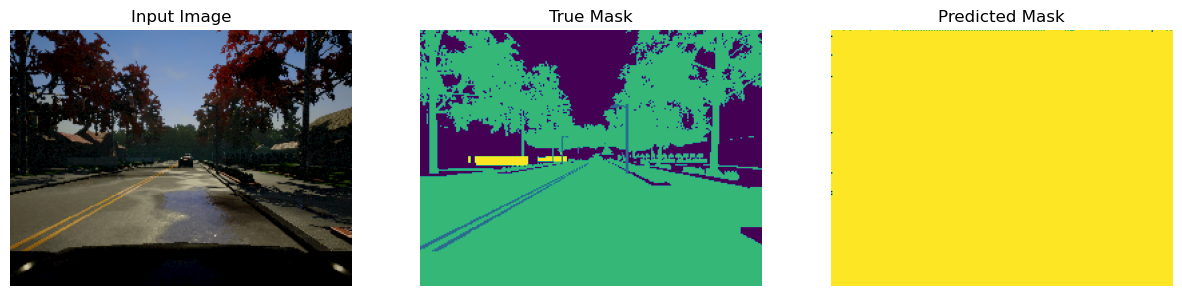

1/1 [==============================] - 0s 27ms/step


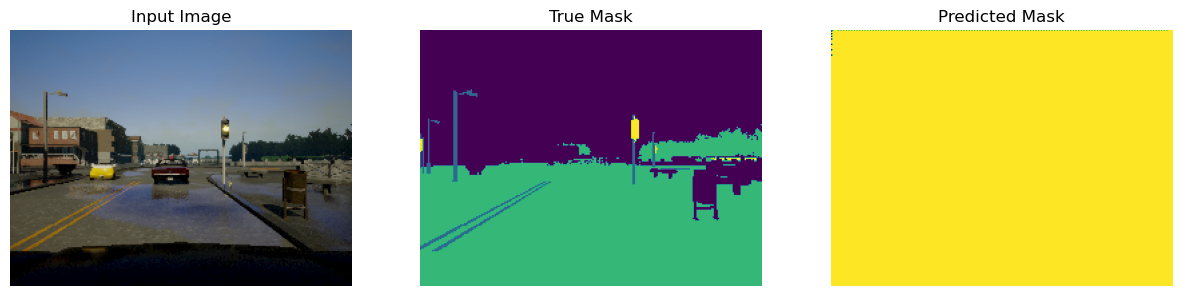

In [131]:
show_predictions(unet_model, train_data, 2)

# More in depth model
Here we will change some things with the original model that may improve the performance. For one, we will remove the dropout rounds, we will also change the Conv2DTranspose into an UpSampling2D layer

In [8]:
def conv2_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x)
    return x

def downsample2_block(x, n_filters):
    f = conv2_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    return f, p

def upsample2_block(x, conv_features, n_filters):
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.concatenate([x, conv_features], axis=3)
    x = conv2_block(x, n_filters)
    return x

In [ ]:
inputs = layers.Input(shape=(256,256,3))

f1, p1 = downsample2_block(inputs, 64)
f2, p2 = downsample2_block(p1, 128)
f3, p3 = downsample2_block(p2, 256)
f4, p4 = downsample2_block(p3, 512)

bottleneck = conv2_block(p4, 1024)

u6 = upsample2_block(bottleneck, f4, 512)
u7 = upsample2_block(u6, f3, 256)
u8 = upsample2_block(u7, f2, 128)
u9 = upsample2_block(u8, f1, 64)

conv10 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
outputs = layers.Conv2D(13, 1, padding='same')(conv10)

unet2_model = tf.keras.Model(inputs, outputs)

In [10]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet2_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = tf.keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

In [ ]:
unet2_model.fit(train_data, epochs=2, validation_data=val_data, callbacks=[callbacks, lr_decrease])

Epoch 1/2
 9/63 [===>..........................] - ETA: 1:19:14 - loss: 6.4890 - accuracy: 0.1524

We see that even though the accuracy is significantly lower, the mask seems to be working better. The accuracy may not be a relevant metric and we may need to use something known as IoU (Intersection over Union) or DSC(Dice similarity coefficient)

2/2 [==============================] - 0s 241ms/step


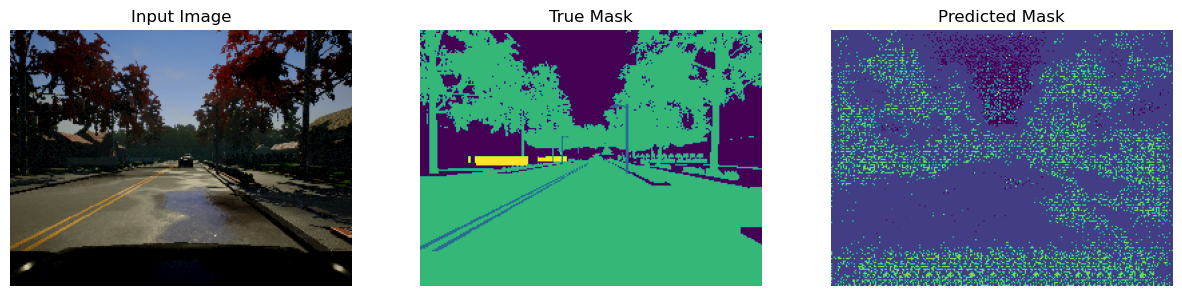

2/2 [==============================] - 0s 126ms/step


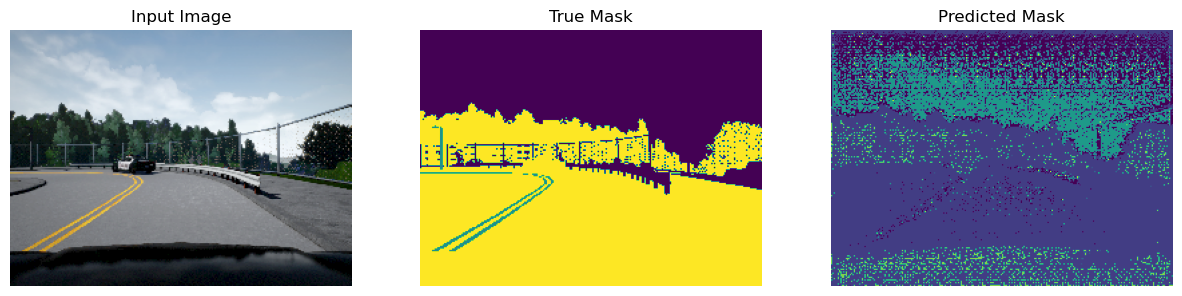

In [ ]:
show_predictions(unet2_model, train_data, 2)

# Test model
Make model more complex

In [ ]:
def conv3_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x, training=True)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(3)(x, training=True)
    x = layers.LeakyReLU()(x)
    return x

def downsample3_block(x, n_filters):
    f = conv3_block(x, n_filters)
    p = layers.MaxPooling2D(2)(f)
    return f, p

def upsample3_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same', kernel_initializer='he_normal')(x)
    x = layers.concatenate([x, conv_features], axis=3)
    x = conv3_block(x, n_filters)
    return x

In [ ]:
inputs = layers.Input(shape=(256,256,3))

f1, p1 = downsample3_block(inputs, 32)
f2, p2 = downsample3_block(p1, 64)
f3, p3 = downsample3_block(p2, 128)
f4, p4 = downsample3_block(p3, 256)

bottleneck = conv3_block(p4, 512)

u6 = upsample3_block(bottleneck, f4, 256)
u7 = upsample3_block(u6, f3, 128)
u8 = upsample3_block(u7, f2, 64)
u9 = upsample3_block(u8, f1, 32)

layer = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(u9)
layer = layers.BatchNormalization(3)(layer, training=True)
layer = layers.LeakyReLU()(layer)
layer = layers.Conv2D(13, 1, padding='same')(layer)
layer = layers.BatchNormalization(3)(layer, training=True)
outputs = layers.LeakyReLU()(layer)

#outputs = layers.Conv2D(13, 1, padding='same')(conv10)

unet3_model = tf.keras.Model(inputs, outputs)

In [ ]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet3_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = tf.keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
lr_decrease = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=True, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True , patience=5, verbose=1)

In [ ]:
unet3_model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[callbacks, lr_decrease, early_stop])

Epoch 1/50
125/125 [==============================] - 43s 333ms/step - loss: 2.0489 - accuracy: 0.4969 - val_loss: 0.6170 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 42s 334ms/step - loss: 0.5262 - accuracy: 0.8034 - val_loss: 0.4751 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 41s 330ms/step - loss: 0.4817 - accuracy: 0.8261 - val_loss: 0.4505 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 41s 328ms/step - loss: 0.3577 - accuracy: 0.8450 - val_loss: 0.3404 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 42s 335ms/step - loss: 0.3546 - accuracy: 0.8540 - val_loss: 0.3389 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 6/50
125/125 [==============================] - 42s 334ms/step - loss: 0.3209 - accuracy: 0.8741 - val_loss: 0.2778 - val_accuracy: 0.8948 - lr: 0.0010
Epoch 7/50
125/125 [==============================] 

1/1 [==============================] - 0s 180ms/step


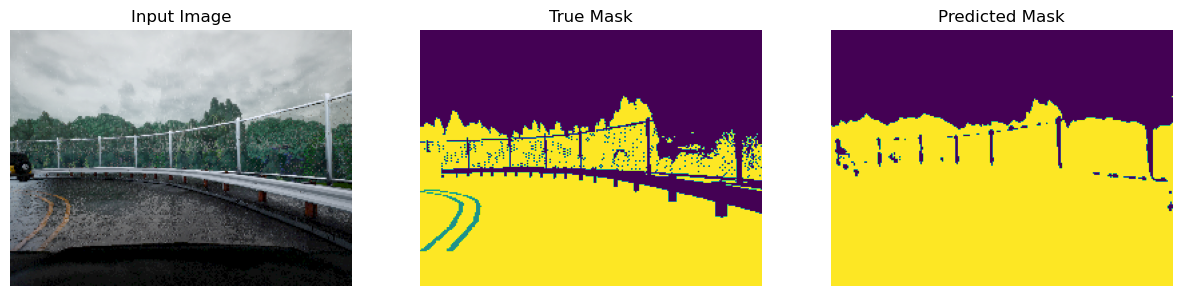

1/1 [==============================] - 0s 28ms/step


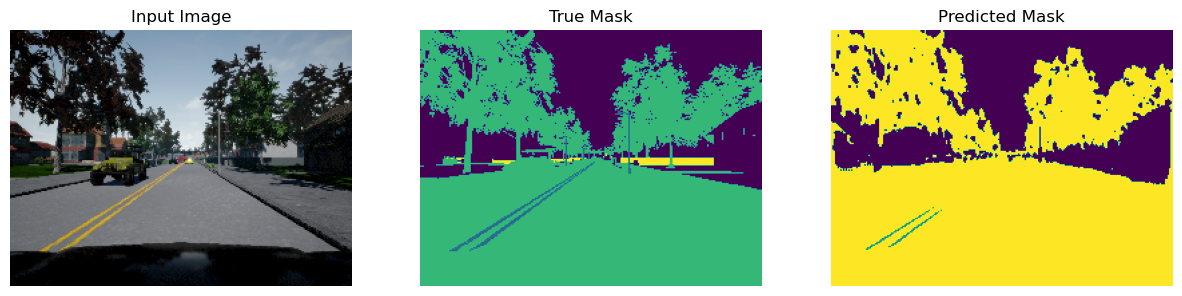

1/1 [==============================] - 0s 24ms/step


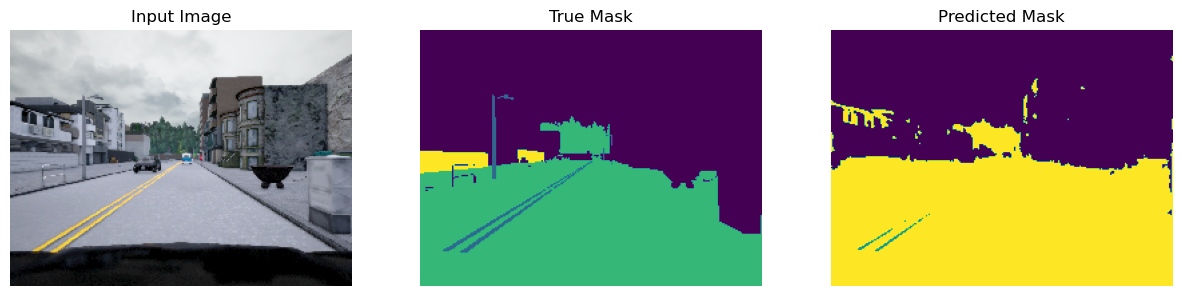

In [ ]:
show_predictions(unet3_model, val_data, 3)